# China meteorological forcing dataset (1979-2018)

http://data.tpdc.ac.cn/en/data/8028b944-daaa-4511-8769-965612652c49/  

Compare this dataset with APHRODITE and CRU 

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

## Load topo at 0.5°

In [10]:
path = '/home/lalandmi/Dropbox/data/GMTED2010/'
ds = xr.open_dataset(path+'GMTED2010_15n120_0500deg.nc') \
    .drop_dims('nbounds') \
    .swap_dims({'nlat': 'latitude', 'nlon': 'longitude'}) \
    .drop({'nlat', 'nlon'}) \
    .rename({'latitude': 'lat', 'longitude': 'lon'}) \
    .sel(lat=latlim_ext, lon=lonlim_ext)

elevation = ds.elevation
elevation_std = ds.elevation_stddev

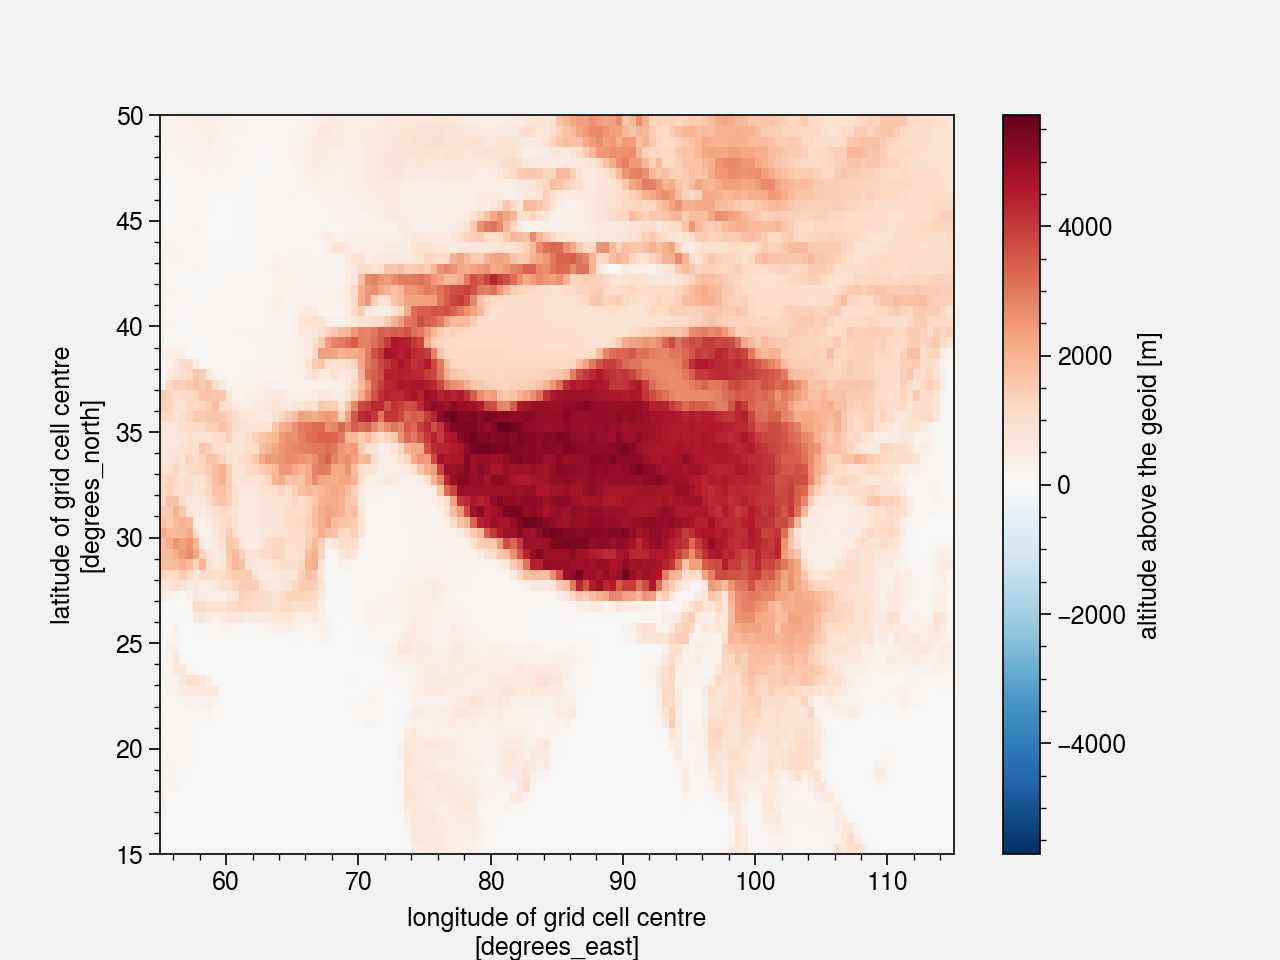

In [12]:
elevation.plot()

## Load CRU (0.5°)

In [54]:
path = '/home/lalandmi/Dropbox/data/CRU/tmp/'

# cru_ts4_00
ds = xr.open_dataset(path+'cru_ts4.00.1901.2015.tmp.dat.nc')
cru_ts4_00 = ds.tmp.sel(time=period, lat=latlim_ext, lon=lonlim_ext)
u.check_period_size(period, cru_ts4_00, ds, frequency='monthly')

# cru_ts4_04
ds = xr.open_dataset(path+'cru_ts4.04.1901.2019.tmp.dat.nc')
cru_ts4_04 = ds.tmp.sel(time=period, lat=latlim_ext, lon=lonlim_ext)
u.check_period_size(period, cru_ts4_04, ds, frequency='monthly')

tas_cru = cru_ts4_04

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


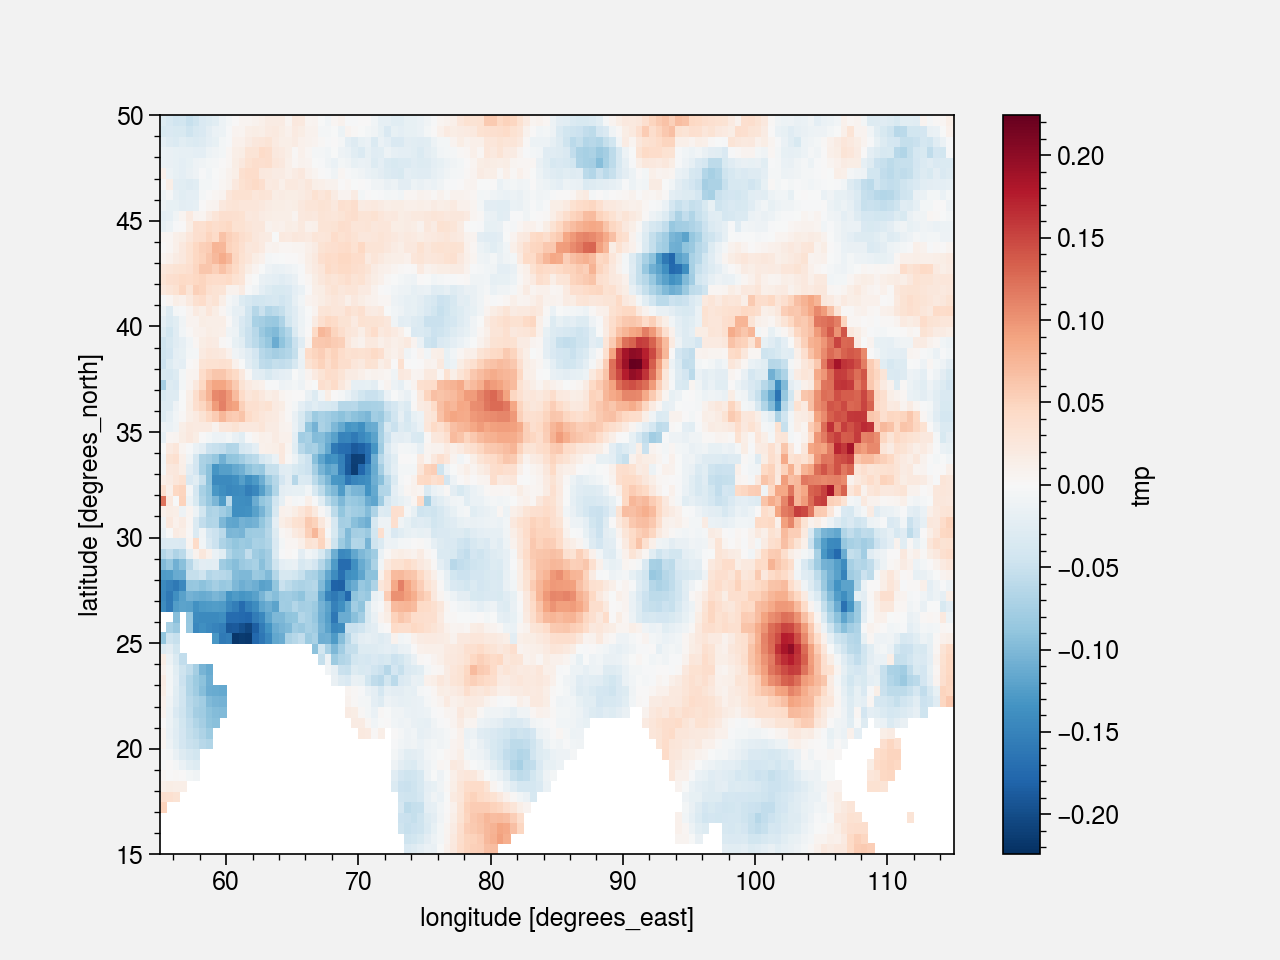

In [9]:
(cru_ts4_00.mean('time') - cru_ts4_04.mean('time')).plot()

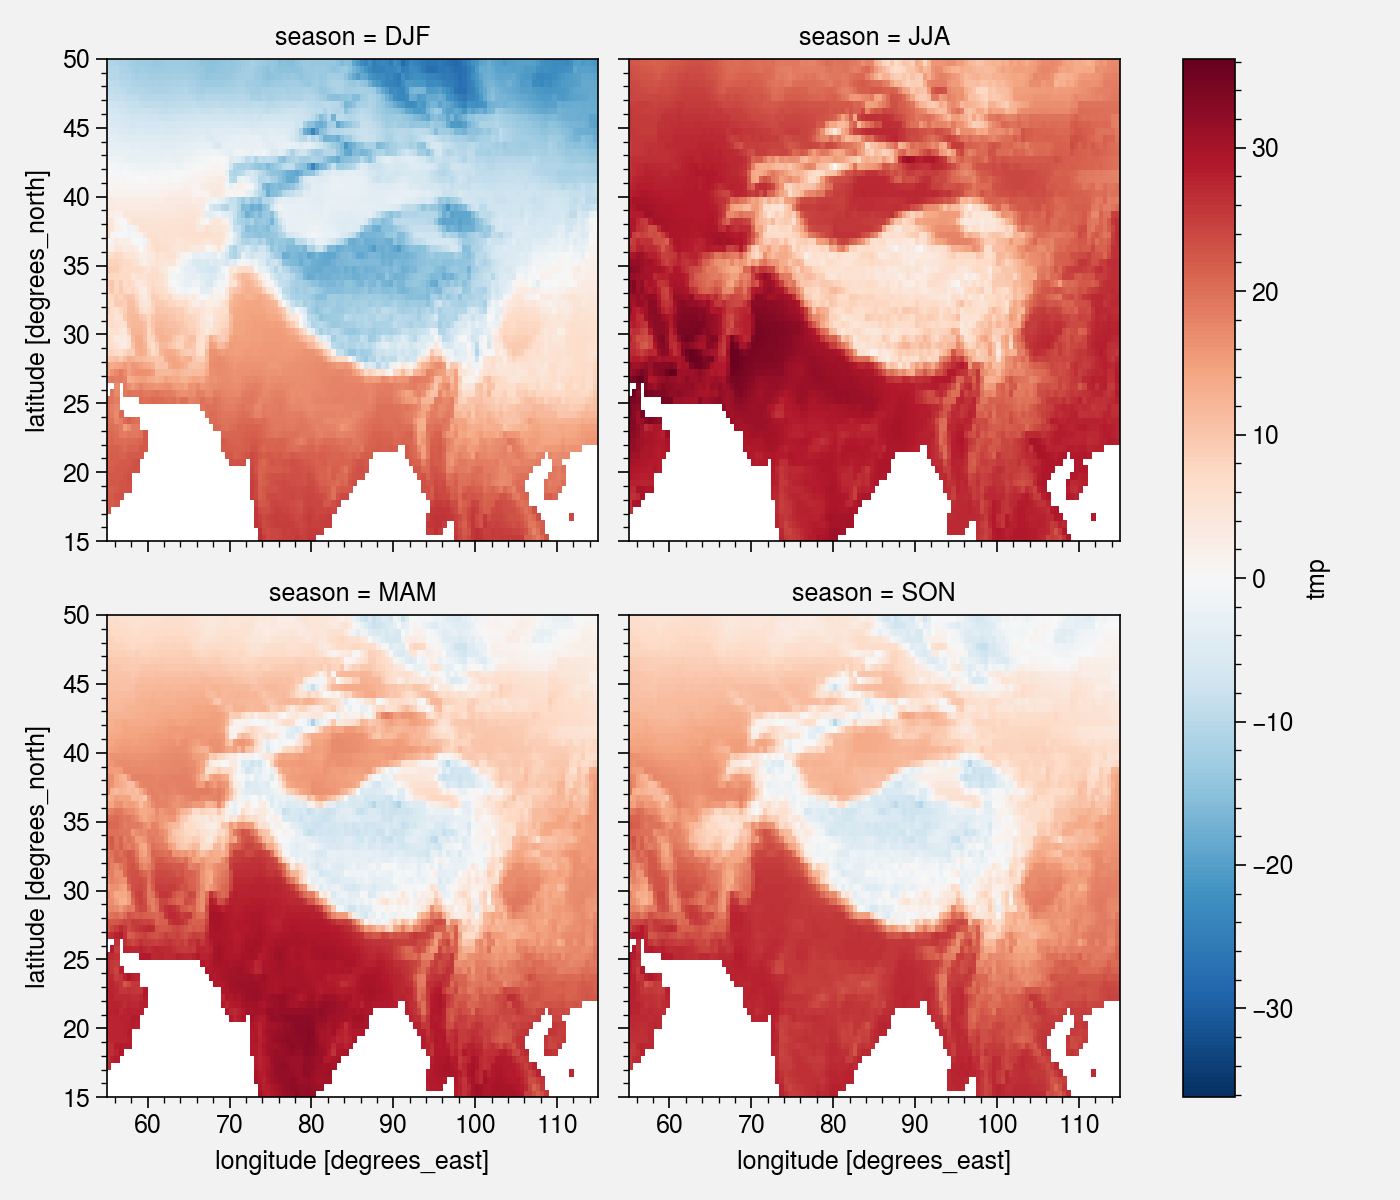

In [15]:
cru_ts4_04.groupby('time.season').mean('time').plot(col='season', col_wrap=2)

## Load APHRODITE

In [25]:
path = '/home/lalandmi/Dropbox/data/APHRODITE/'

obs_V1101 = xr.open_mfdataset(path+'APHRO_MA_050deg_V1101.*.nc', combine='by_coords').precip
obs_V1101_EXR1 = xr.open_mfdataset(path+'APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords').precip

obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = (xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')).sel(time=period)

# Resamble data per month (from per day)
pr_aphro = obs.resample(time='1M').mean('time', skipna=False, keep_attrs=True).load()

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, pr_aphro.time.size)

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


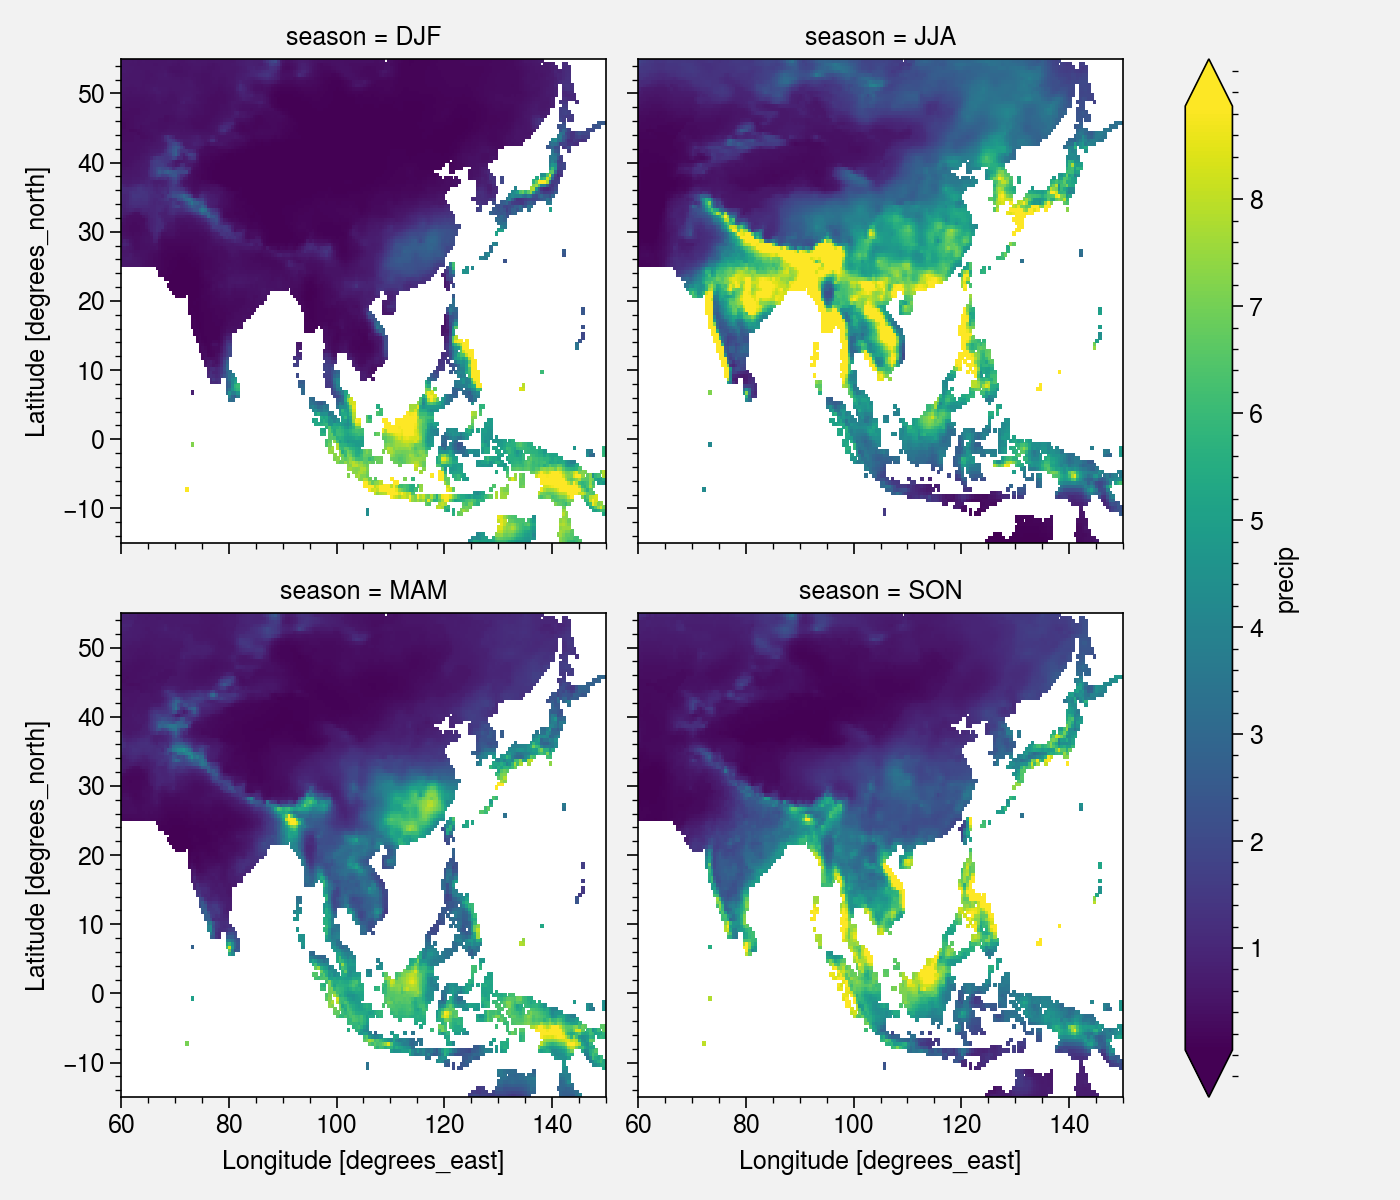

In [28]:
pr_aphro.groupby('time.season').mean('time').plot(col='season', col_wrap=2, robust=True)

## Load CMFD

### Temp

In [106]:
path = '/home/lalandmi/Dropbox/data/TPDC/china_meteorological_forcing_dataset_1979_2018/Data_forcing_01mo_010deg/'

ds = xr.open_dataset(path+'temp_CMFD_V0106_B-01_01mo_010deg_197901-201812.nc')
tas_cmfd = ds.temp.sel(time=period, lat=latlim_ext, lon=lonlim_ext)
tas_cmfd -= 273.15
u.check_period_size(period, tas_cmfd, ds, frequency='monthly')

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


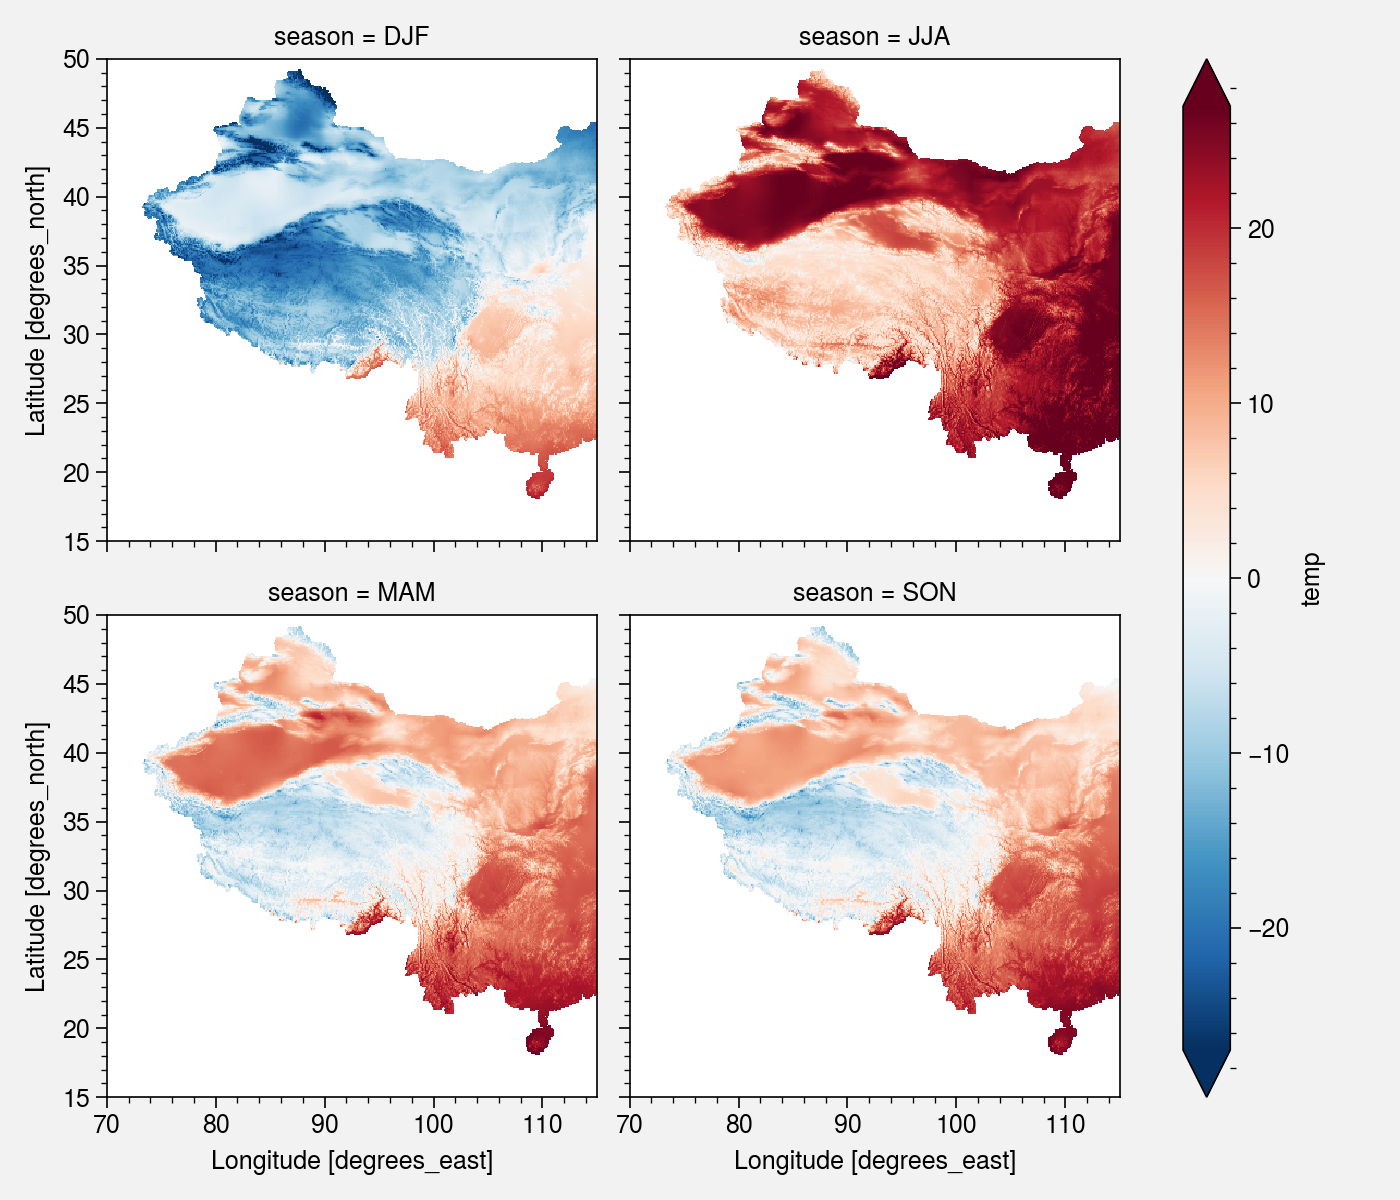

In [50]:
tas_cmfd.groupby('time.season').mean('time').plot(col='season', col_wrap=2, robust=True)

### Precip

In [115]:
path = '/home/lalandmi/Dropbox/data/TPDC/china_meteorological_forcing_dataset_1979_2018/Data_forcing_01mo_010deg/'

ds = xr.open_dataset(path+'prec_CMFD_V0106_B-01_01mo_010deg_197901-201812.nc')
pr_cmfd = ds.prec.sel(time=period, lat=latlim_ext, lon=lonlim_ext)
pr_cmfd *= 24
u.check_period_size(period, pr_cmfd, ds, frequency='monthly')

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


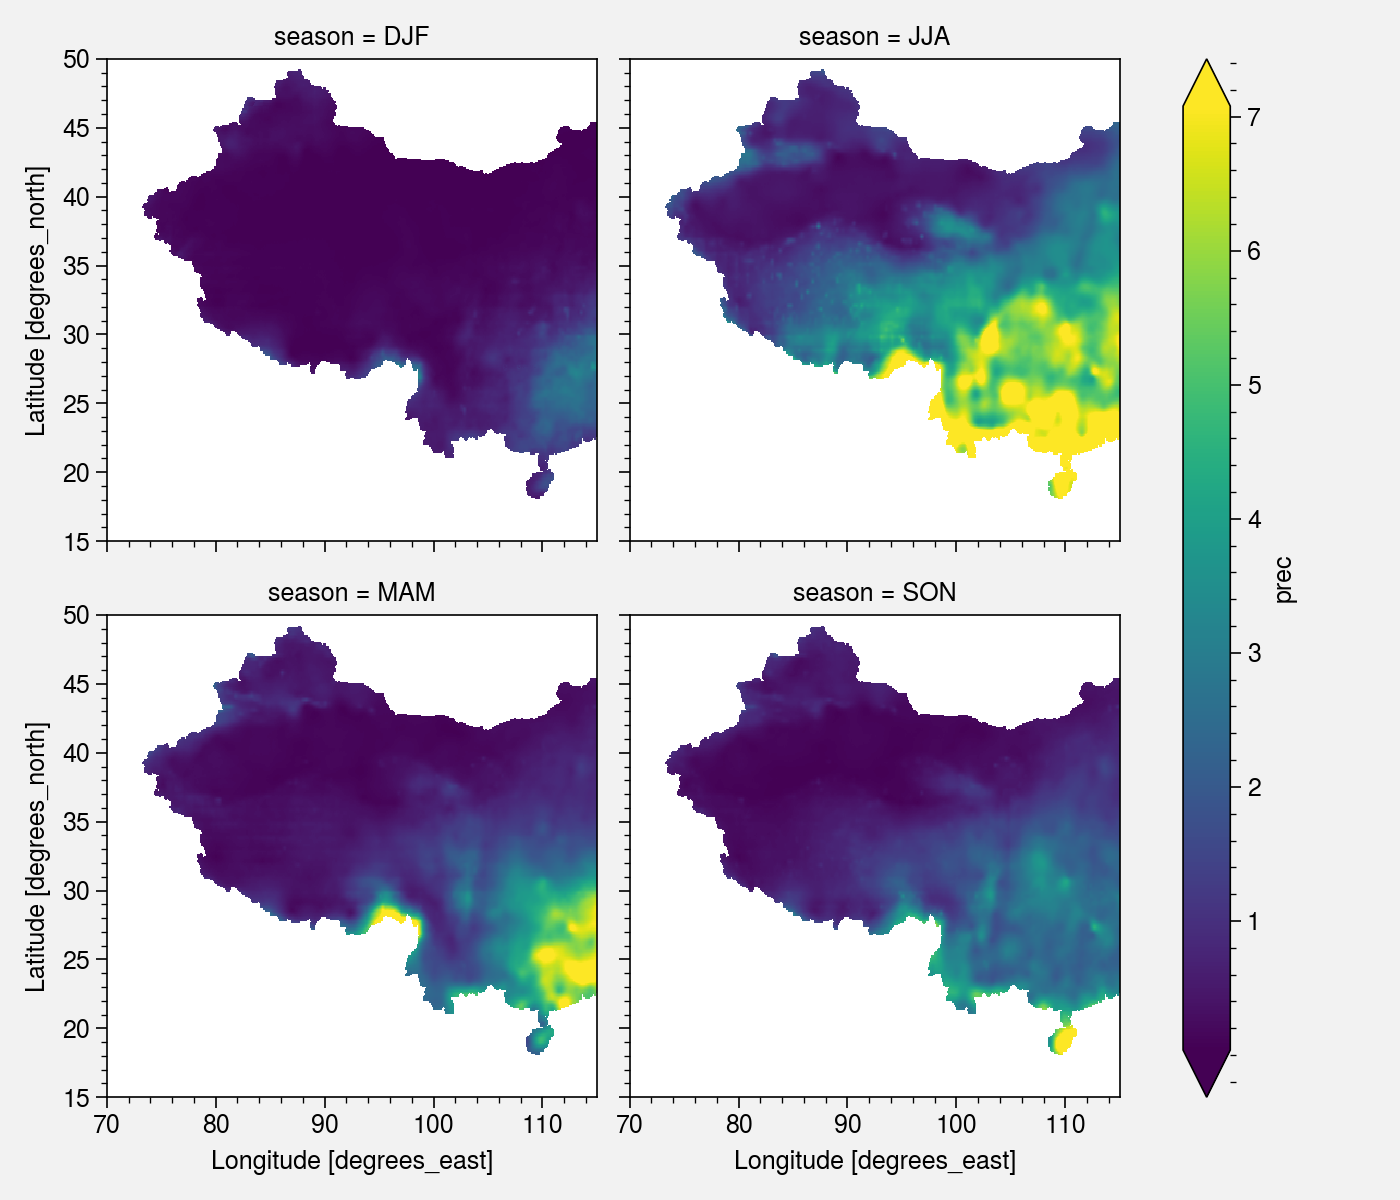

In [116]:
pr_cmfd.groupby('time.season').mean('time').plot(col='season', col_wrap=2, robust=True)

## Regrid

In [61]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

In [67]:
regridder = xe.Regridder(tas_cru, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
tas_cru_regrid = regridder(tas_cru)

regridder = xe.Regridder(tas_cmfd, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
tas_cmfd_regrid = regridder(tas_cmfd)

regridder = xe.Regridder(pr_aphro, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
pr_aphro_regrid = regridder(pr_aphro)

regridder = xe.Regridder(pr_cmfd, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
pr_cmfd_regrid = regridder(pr_cmfd)

Reuse existing file: bilinear_70x120_70x120.nc
Reuse existing file: bilinear_350x450_70x120.nc
Reuse existing file: bilinear_140x180_70x120.nc
Reuse existing file: bilinear_350x450_70x120.nc


## Plot

### Temp

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


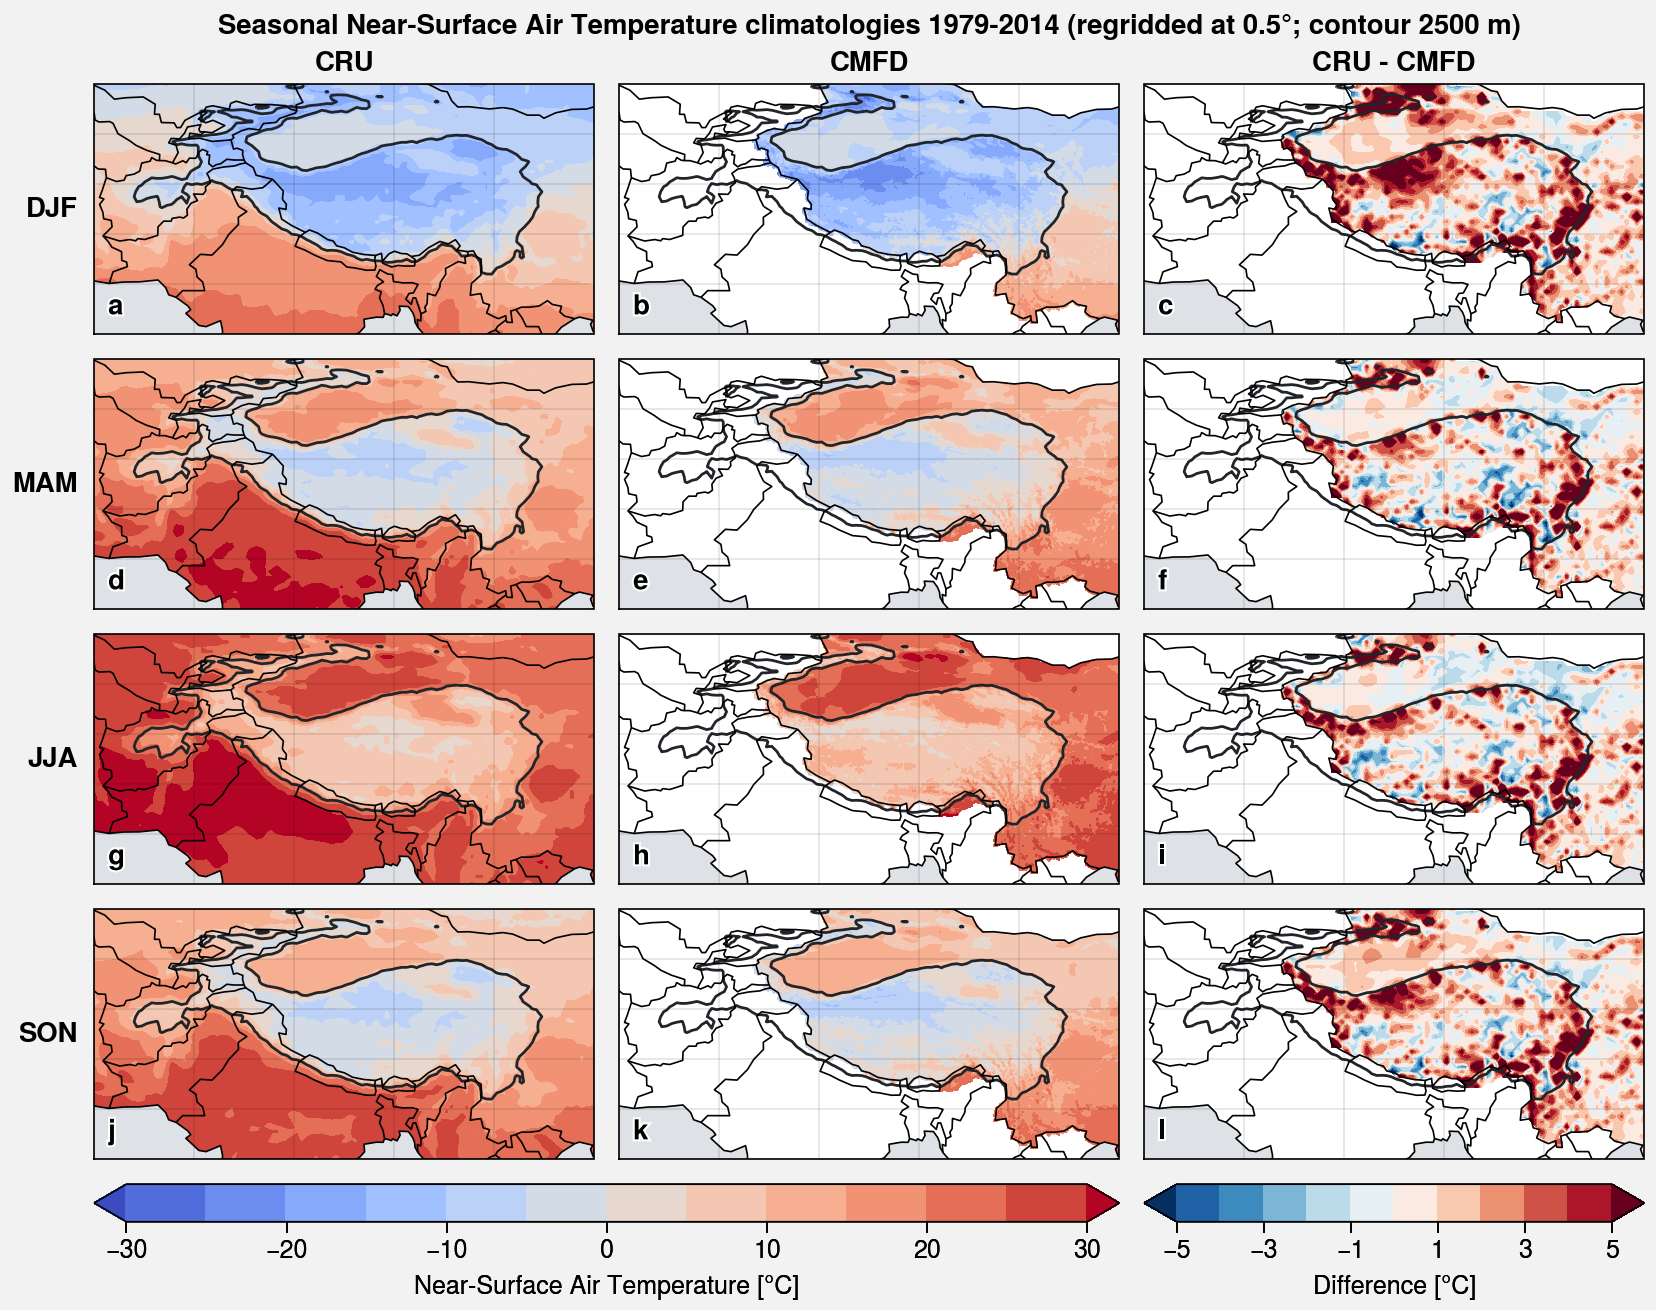

In [127]:
seasons = ['DJF', 'MAM', 'JJA', 'SON']
var = 'tas'

label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

obs_list = [
    tas_cru.groupby('time.season').mean('time'),
    tas_cmfd.groupby('time.season').mean('time'),
    tas_cru.groupby('time.season').mean('time') \
        - tas_cmfd.groupby('time.season').mean('time')
    
]

obs_list_names = ['CRU', 'CMFD', 'CRU - CMFD']

fig, axs = plot.subplots(ncols=len(obs_list), nrows=len(seasons), proj='cyl')

k = 0
for season in seasons:
    
    # CMFD
    m1 = axs[k].contourf(obs_list[0].sel(season=season), cmap=cmap, levels=levels, extend='both')
    k += 1
    
    # CRU
    axs[k].contourf(obs_list[1].sel(season=season), cmap=cmap, levels=levels, extend='both')
    k += 1
    
    # CMFD - CRU
    m2 = axs[k].contourf(obs_list[2].sel(season=season), cmap=cmap_diff, levels=levels_diff, extend='both')
    k += 1

# fig.colorbar(m, label='Snow Cover Extent [%]') 
fig.colorbar(m1, label=label+' ['+units+']', loc='b', cols=(1, 2))
fig.colorbar(m2, label='Difference ['+units+']', loc='b', col=3)

for ax in axs:
    ax.contour(elevation, levels=[2500], color='gray9', linewidth=1)

axs.format(
    # Grids, labels and limits
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=True, abcloc='ll',
    collabels=obs_list_names, rowlabels=seasons,
    suptitle='Seasonal '+label+' climatologies '+period.start+'-'+period.stop+' (regridded at 0.5°; contour 2500 m)'
)

# fig.save('img/'+var+'_seas_clim_CRU-CMFD.jpg')

## Precip

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


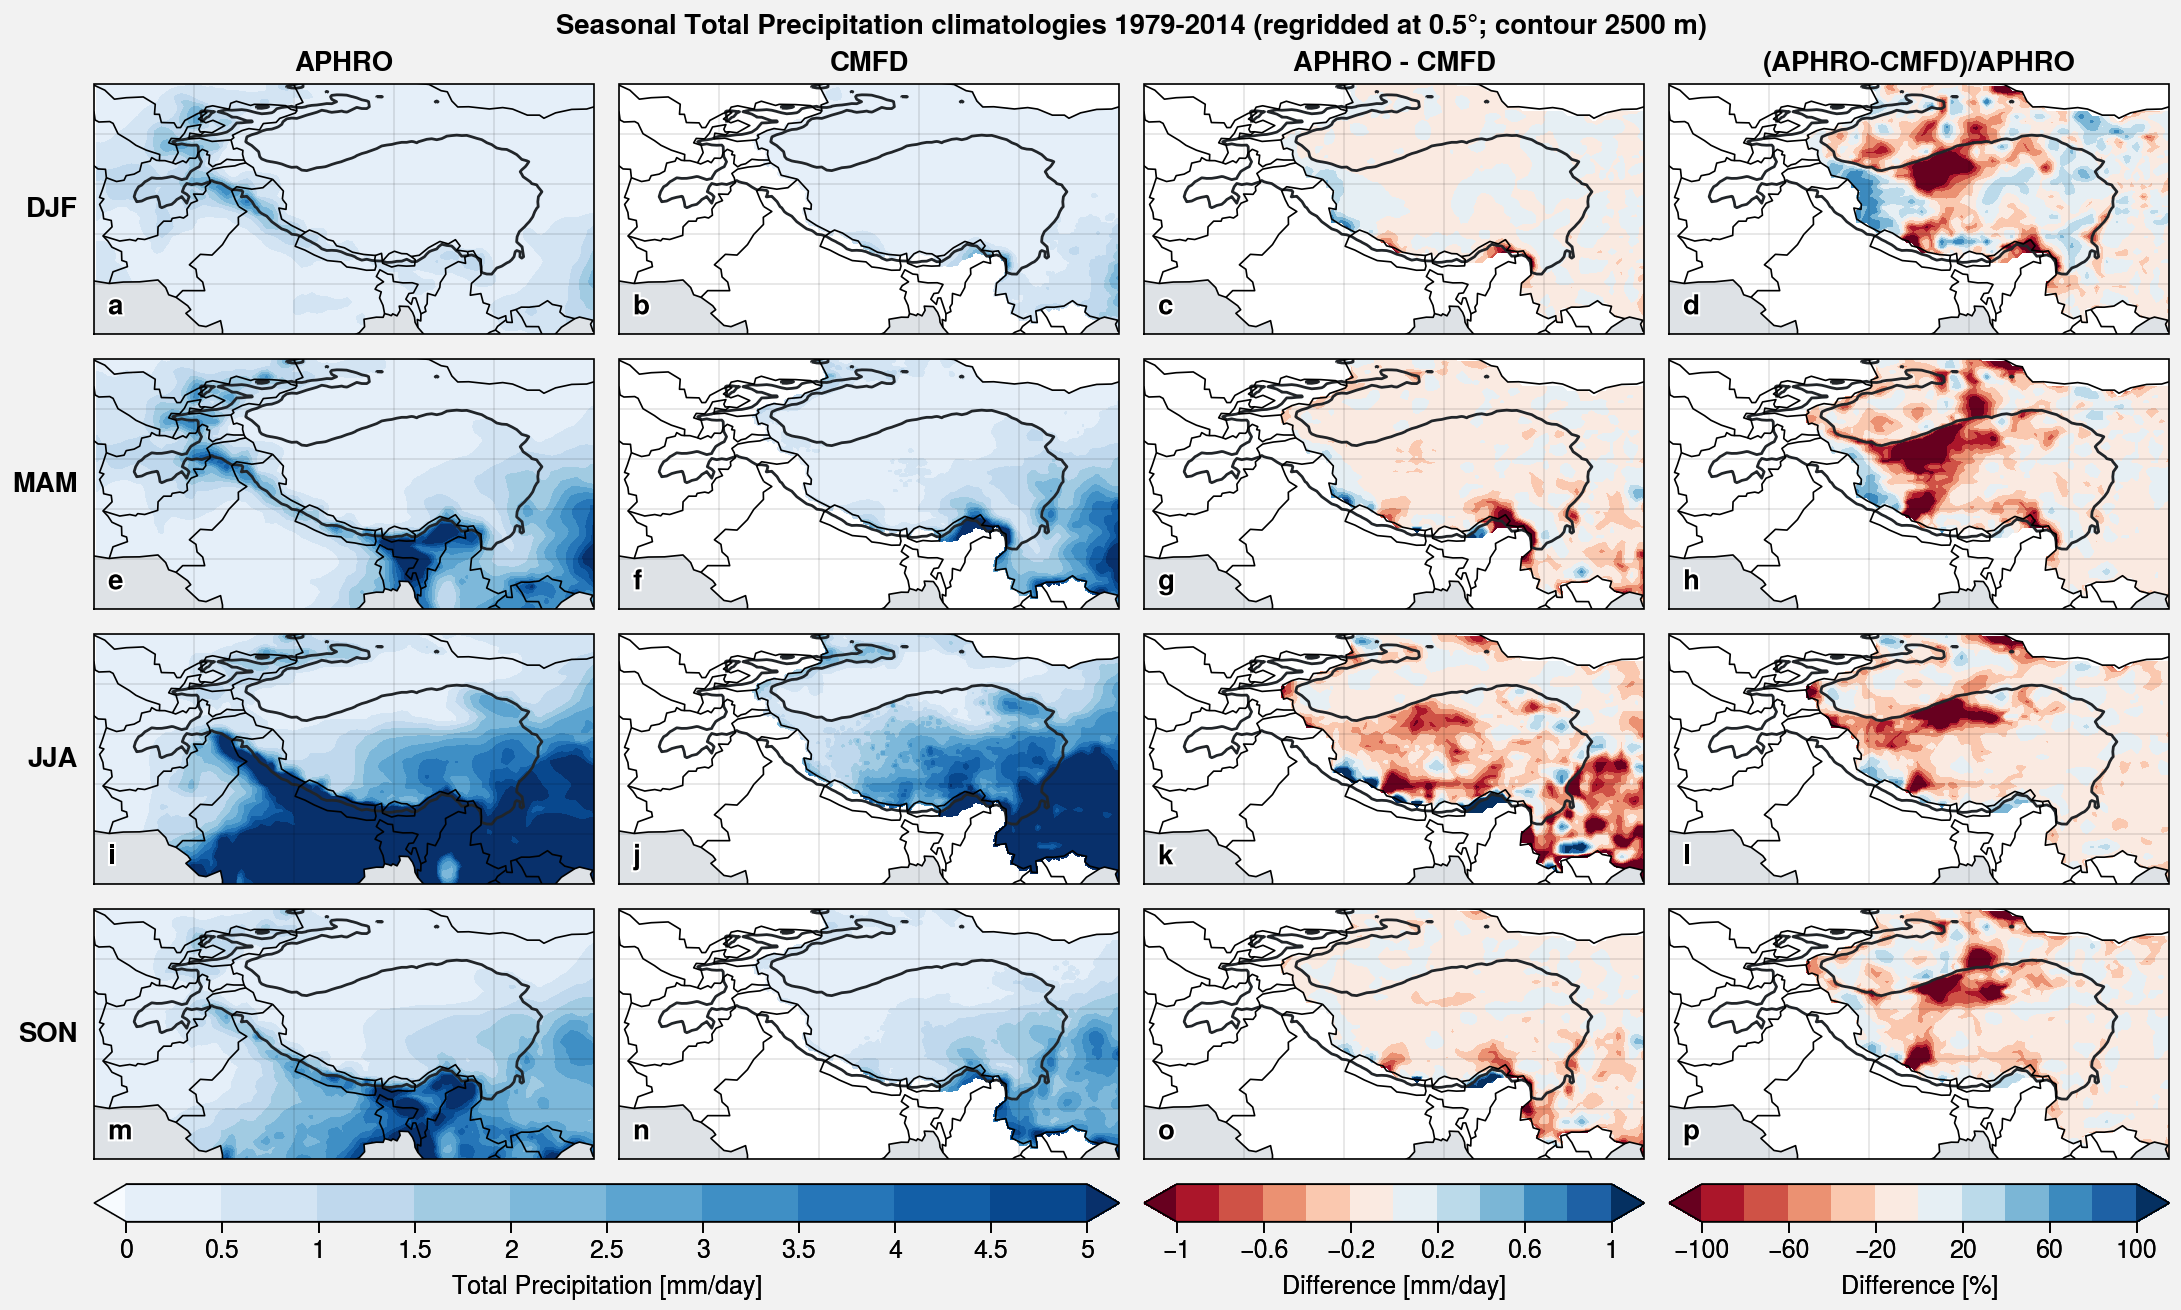

In [131]:
seasons = ['DJF', 'MAM', 'JJA', 'SON']
var = 'pr'

label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

cmap = 'Blues'
# levels = plot.arange()

obs_list = [
    pr_aphro.groupby('time.season').mean('time'),
    pr_cmfd.groupby('time.season').mean('time'),
    pr_aphro.groupby('time.season').mean('time') \
        - pr_cmfd.groupby('time.season').mean('time'),
    (pr_aphro.groupby('time.season').mean('time') \
        - pr_cmfd.groupby('time.season').mean('time')) \
        / pr_aphro.groupby('time.season').mean('time') * 100
    
]

obs_list_names = ['APHRO', 'CMFD', 'APHRO - CMFD', '(APHRO-CMFD)/APHRO']

fig, axs = plot.subplots(ncols=len(obs_list), nrows=len(seasons), proj='cyl')

k = 0
for season in seasons:
    
    # CMFD
    m1 = axs[k].contourf(obs_list[0].sel(season=season), cmap=cmap, levels=levels, extend='both')
    k += 1
    
    # CRU
    axs[k].contourf(obs_list[1].sel(season=season), cmap=cmap, levels=levels, extend='both')
    k += 1
    
    # CMFD - CRU
    m2 = axs[k].contourf(obs_list[2].sel(season=season), cmap=cmap_diff, levels=levels_diff, extend='both')
    k += 1
    
    # CMFD - CRU
    m3 = axs[k].contourf(obs_list[3].sel(season=season), cmap=cmap_diff, levels=levels_diff*100, extend='both')
    k += 1

# fig.colorbar(m, label='Snow Cover Extent [%]') 
fig.colorbar(m1, label=label+' ['+units+']', loc='b', cols=(1, 2))
fig.colorbar(m2, label='Difference ['+units+']', loc='b', col=3)
fig.colorbar(m3, label='Difference [%]', loc='b', col=4)

for ax in axs:
    ax.contour(elevation, levels=[2500], color='gray9', linewidth=1)

axs.format(
    # Grids, labels and limits
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=True, abcloc='ll',
    collabels=obs_list_names, rowlabels=seasons,
    suptitle='Seasonal '+label+' climatologies '+period.start+'-'+period.stop+' (regridded at 0.5°; contour 2500 m)'
)

fig.save('img/'+var+'_seas_clim_APHRO-CMFD.jpg')